In [2]:
from datetime import datetime, timedelta
from time import sleep

import pandas
import requests

# get data from gdax and try to plot 
class GDAX(object): 
    def __init__(self, pair):
        self.pair = pair
        self.uri = 'https://api.gdax.com/products/{pair}/candles'.format(pair = self.pair)
        
    @staticmethod
    def __date_to_iso8601(date):
        """Convert a datetime object to the ISO-8601 date format (expected by the GDAX API).
        Args:
          date (datetime): The date to be converted.
        Returns:
          str: The ISO-8601 formatted date.
        """
        return '{year}-{month:02d}-{day:02d}T{hour:02d}:{minute:02d}:{second:02d}'.format(
            year=date.year,
            month=date.month,
            day=date.day,
            hour=date.hour,
            minute=date.minute,
            second=date.second)
    
    def request_slice(self, start, granularity):
        # start : datetime, granularity: in seconds (int) 
        end = start + timedelta(seconds = granularity*350)
        # Allow 3 retries (we might get rate limited).
        retries = 3
        for retry_count in xrange(0, retries):
          # From https://docs.gdax.com/#get-historic-rates the response is in the format:
          # [[time, low, high, open, close, volume], ...]
          response = requests.get(self.uri, {
            'start': GDAX.__date_to_iso8601(start),
            'end': GDAX.__date_to_iso8601(end),
            'granularity': granularity * 60  # GDAX API granularity is in seconds.
          })

        if response.status_code != 200 or not len(response.json()):
            if retry_count + 1 == retries:
                raise Exception('Failed to get exchange data for ({}, {})!'.format(start, end))
            else:
                # Exponential back-off.
                sleep(0.5 ** retry_count)
        else:
            # Sort the historic rates (in ascending order) based on the timestamp.
            result = sorted(response.json(), key=lambda x: x[0])
            return result
    
    
      def fetch(self, start, end, granularity):
        """Fetch the candle data for a given range and granularity.
        Args:
          start (datetime): The start of the date range.
          end (datetime): The end of the date range (excluded).
          granularity (int): The granularity of the candles data (in minutes).
        Returns:
          (pandas.DataFrame): A data frame of the OHLC and volume information, indexed by their unix timestamp.
        """
        data = []

        # We will fetch the candle data in windows of maximum 100 items.
        # GDAX has a limit of returning maximum of 200, per request.
        delta = timedelta(minutes=granularity * 100)

        slice_start = start
        while slice_start != end:
          slice_end = min(slice_start + delta, end)
          data += self.request_slice(slice_start, slice_end, granularity)
          slice_start = slice_end

        data_frame = pandas.DataFrame(data=data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
        data_frame.set_index('time', inplace=True)
        return data_frame

(44454, 6)
total opportunities 28.6565888334%
total opportunities 32.3188014577%
0.0970441355109


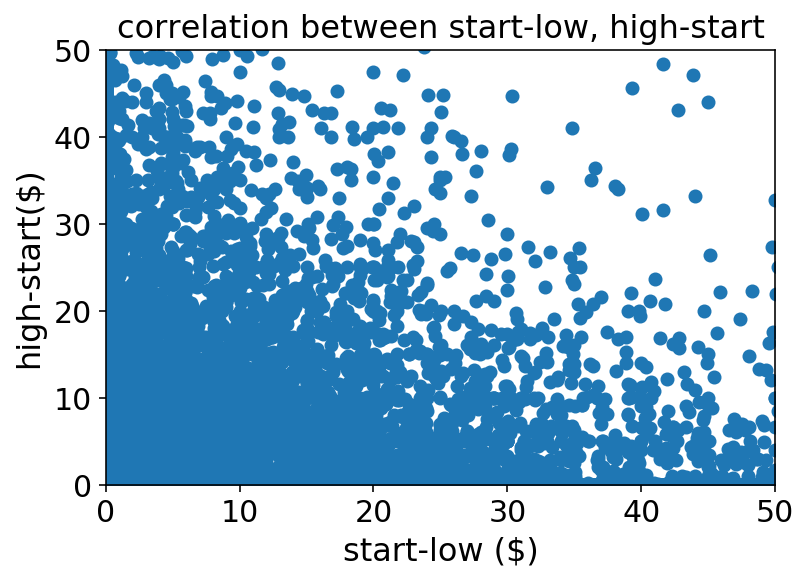

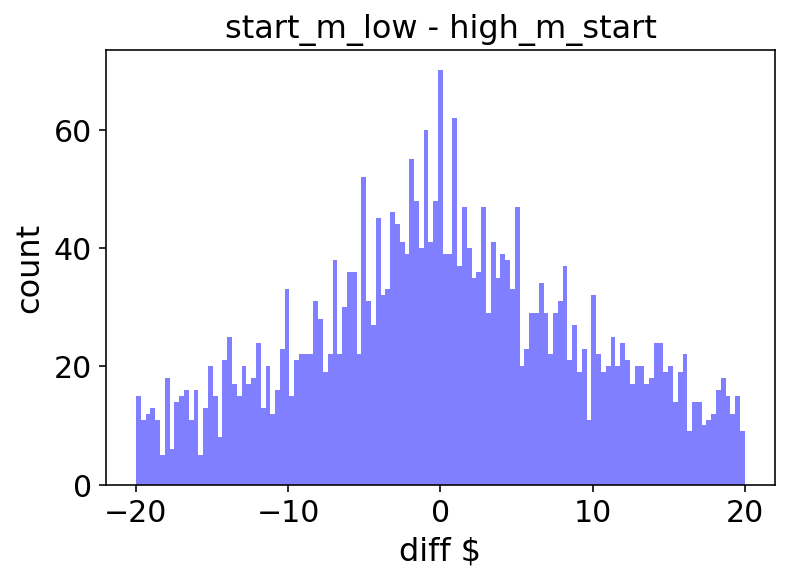

In [120]:
# draw histogram 
# read data
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

def aboveLimit(arr, lower):
    # return boolean 
    return arr > lower
    
def withinRange(arr, lower, upper): 
    return arr[(arr < upper) & (arr> lower)]

def plotHist(arr, xlabel, ylabel, title, lower, upper): 
    num_bins = 127
    fontSize = 16
    fig, ax = plt.subplots(dpi=144)
    ax.hist(withinRange(arr, lower, upper), num_bins, facecolor='blue', alpha=0.5)
    ax.set_xlabel(xlabel, fontsize=fontSize)
    ax.set_ylabel(ylabel, fontsize=fontSize)
    ax.set_title(title, fontsize = fontSize)
    ax.tick_params(labelsize = 15)

def plotScatter(x, y, xlabel, ylabel, title, xylimits=[]):
    fig, ax = plt.subplots(dpi=144)
    fontSize = 16
    ax.scatter(x, y)
    ax.set_xlabel(xlabel, fontsize=fontSize)
    ax.set_ylabel(ylabel, fontsize=fontSize)
    ax.set_title(title, fontsize = fontSize)
    ax.tick_params(labelsize = 15)
    if xylimits: 
        ax.set_xlim(xylimits[0], xylimits[1])
        ax.set_ylim(xylimits[0], xylimits[1])

def plotLine(x, y): 
    fig, ax = plt.subplots(dpi=144)
    fontSize = 16
    ax.scatter(x, y)
    
filename = "data_1month.json"
with open(filename, 'r') as f: 
    data = np.array(json.load(f))
    print data.shape
    (time, low, high, start, end, volume) = [data[:, i] for i in xrange(data.shape[1])]
    xlabel = "bitCoins"
    ylabel = "count"
    vol_title = "Volume"
    #plotHist(volume, xlabel, ylabel, vol_title, -1, 20.0)
    
    xlabel = "dollar"
    start_m_low = start-low
    #plotHist(start_m_low, xlabel, ylabel, "start - low", 0.1, 20.0)
    print("total opportunities {}%".format(100*len(withinRange(start_m_low, 0.2, 20))/float(len(start))))
    
    high_m_start = high - start
    #plotHist(high_m_start, xlabel, ylabel, "high - start", 0.1, 20.0)
    print("total opportunities {}%".format(100*len(withinRange(high_m_start, 0.2, 20))/float(len(start))))
    
    plotScatter(start_m_low, high_m_start, "start-low ($)", "high-start($)", "correlation between start-low, high-start", [0,50])
    
    # difference between start-low and high-start (diff between bitcoin going up and bitcoin going down)
    up_m_down = start_m_low - high_m_start
    # then filter it based on aboveLimit, meaning we want start_m_low > a $ amount
    up_m_down = up_m_down[aboveLimit(start_m_low, 1) & aboveLimit(high_m_start,1 )]
    print(float(len(up_m_down))/len(start_m_low))
    plotHist(up_m_down, "diff $", ylabel, "start_m_low - high_m_start", -20, 20)


In [52]:
from datetime import datetime, timedelta

datetime(2017,12,31) + timedelta(seconds = 60*100)

datetime.datetime(2017, 12, 31, 1, 40)

<generator object <genexpr> at 0x115127230>

ValueError: need more than 2 values to unpack